# 1. DATA EXPLORATION

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Preprocessing and Feature Engineering
from textblob import TextBlob
import re 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
df = pd.read_excel('sentences_with_sentiment.xlsx')

In [3]:
df = df[['Sentence','Positive','Negative','Neutral']].drop_duplicates()

In [4]:
(df ['Positive']+df ['Negative']+df ['Neutral']).value_counts()

1    236
dtype: int64

In [5]:
df['label'] = df[['Positive','Negative','Neutral']].idxmax(axis=1)

In [6]:
df[['Sentence','label']].to_excel('sentiment_sentences.xlsx',index=False)

In [7]:
df_label_count = df['label'].value_counts().reset_index()

In [8]:
df_label_count

,index,label
0,Positive,140
1,Neutral,64
2,Negative,32


In [9]:
pd.set_option('max_colwidth',None)
df[['Sentence','label']].sample(10)

,Sentence,label
74,"The study has been performed under fed conditions, which reflects recommendations in the brand leader’s SPC for the administration of the product.",Positive
114,No clinically relevant added benefit of additional treatment cycles beyond year 2 was evident.,Neutral
184,"The current studies do not provide evidence that the treatment effects persist with indefinite length of treatment, neither in infantile nor in later onset SMA",Negative
84,The safety observation is based on a total of 3354 patients exposed to at least 1 dose of sarilumab for a total of 5981.0 patient-years of exposure.,Neutral
33,The superiority to placebo was demonstrated for both dupilumab doses as monotherapy or in combination with TCS in AD patients who are insufficiently controlled with topical therapies alone.,Positive
63,"For the purpose of the clinical biosimilarity exercise for biosimilar insulin products, the evaluation of HbA1c is not a sensitive endpoint and therefore efficacy studies evaluating HbA1c are not requested (EMEA/CHMP/BMWP/32775/2005_Rev.",Neutral
175,The safety profile of ABP 501 and Humira is considered comparable.,Positive
45,"Overall, the safety profile of PPS is not considered of concern.",Positive
32,This is in accordance with the relevant guideline and additional clinical studies were not considered necessary.,Positive
186,"PAES: In order to evaluate the long term efficacy and safety of Nusinersen in symptomatic patients with spinal muscular atrophy, Phase 3, open-label extension study (SHINE, CS11)",Negative


In [10]:
df['Sentence'].apply(lambda x:len(x.split(' '))).value_counts()

18    13
24    11
16    11
21    11
11    10
13    10
15     9
23     9
25     8
22     8
20     8
10     7
12     7
19     7
17     7
26     6
28     6
39     6
41     6
27     5
30     5
34     5
31     5
14     5
35     4
29     4
9      4
36     4
32     3
45     3
55     3
40     3
38     2
44     2
50     2
43     2
8      2
54     2
58     1
37     1
63     1
62     1
48     1
49     1
7      1
59     1
42     1
33     1
46     1
Name: Sentence, dtype: int64

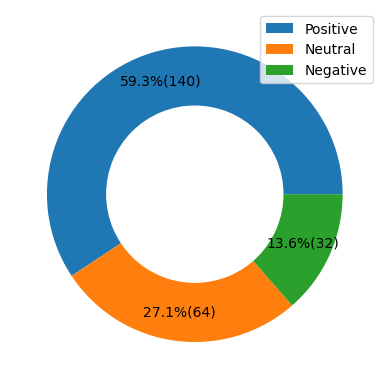

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # display number and percentage
        return '{p:.1f}%({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(df_label_count['label'],pctdistance=0.8,autopct=make_autopct(df_label_count['label']))
plt.pie([1],radius=0.6,colors='w')
plt.legend(df_label_count['index'],loc='upper right')

In [12]:
pd.options.display.notebook_repr_html=False  # 表格显示
plt.rcParams['figure.dpi'] = 75  # 图形分辨率
sns.set_theme(style='darkgrid')  # 图形主题

<AxesSubplot: xlabel='label', ylabel='count'>

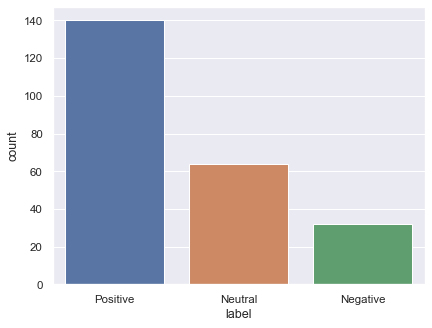

In [13]:
sns.countplot(x='label',data=df)

## 1.1 Preprocessing: Clean Texts

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
import pandas as pd
from bs4 import BeautifulSoup
import re

In [16]:
def from_sentence(text):
    text_blob = TextBlob(text)
    return ' '.join(text_blob.words)

def no_stopwords(text):
    stop_words = stopwords.words('english')
    stop_words = list(set(stop_words)-{'no','nor','not',"don't","aren't",
                                      "couldn't","didn't", "doesn't", "hadn't",
                                      "hasn't",  "haven't", "isn't",  "mightn't",
                                      "mustn't",  "needn't",  "shan't", "shouldn't",
                                       "wasn't", 'weren', "weren't",  "won't", "wouldn't"})
    clean_tokens = [t for t in text.split() if re.match(r'[^\W\d]*\w*$',t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word.lower() for word in clean_s.split() if word.lower() not in stop_words]
    return clean_mess

def normalization(text_list):
    lem = WordNetLemmatizer()
    normalized_words = []
    for word in text_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_words.append(normalized_text)
    return normalized_words

In [17]:
df['clean_sentence'] = df['Sentence'].apply(lambda x:' '.join(normalization(no_stopwords(from_sentence(x)))))

In [17]:
def review_to_words(raw_review):    
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z\d]", " ", review_text) 
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    # 4. In Python, searching a set is much faster than searching
    stops = set(stopwords.words("english"))                  
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return ' '.join(meaningful_words)

In [18]:
df['clean_text'] = df['Sentence'].apply(lambda x:review_to_words(x))

/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


## 1.2 Word Cloud

In [19]:
from wordcloud import STOPWORDS,WordCloud
from collections import Counter

stop_words = STOPWORDS
#stop_words.update(['data','patients','study','studies','results','considered','will'])
#wordcount = Counter([word for word in ' '.join(df['clean_text']).split(' ') \
#                     if len(word) > 1])
wordcount = Counter([word for word in ' '.join(df['clean_sentence']).split(' ')\
                     if len(word) > 1])

In [20]:
def get_plt(data, title):
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    fig, ax = plt.subplots()
    ax.barh(range(len(x)), y, color='gold')
    ax.set_yticks(range(len(x)))
    ax.set_yticklabels(x)
    plt.title(title, fontsize=10)
    plt.ylabel("word")
    plt.xlabel('count')
    plt.show()

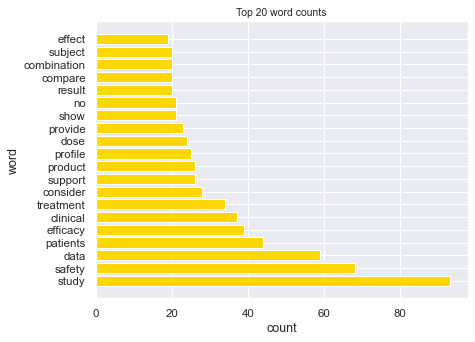

In [21]:
get_plt(wordcount.most_common(20),'Top 20 word counts')

In [34]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt

cloud_mask = np.array(Image.open("/Users/yuxueqi/Downloads/心形.png"))

In [36]:
wc = WordCloud(stopwords=stop_words)

wc = WordCloud(background_color="white", 
    mask=cloud_mask)
wc.generate(' '.join(df[df['label']=='Positive']['clean_sentence']))

wc.to_file("positive_wordcloud.png")

In [39]:
wc.generate(' '.join(df[df['label']=='Negative']['clean_sentence']))

wc.to_file("negative_wordcloud.png")

In [40]:
wc.generate(' '.join(df[df['label']=='Neutral']['clean_sentence']))

wc.to_file("neutral_wordcloud.png")

# 2. Rule Based Methods

## 2.1 VADER FROM RULES

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix

In [37]:
def plot_prediction_bar(column,method):
    '''
    bar plot of prediction vs truth
    '''
    confusion_mat = confusion_matrix(df['label'],df[column])

    ind = [0,5,10]    # the x locations for the groups
    width = 1       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, confusion_mat[2,:],width, color='#d62728')#, yerr=menStd)
    p2 = plt.bar(ind, confusion_mat[1,:], width,bottom = confusion_mat[2,:])#, yerr=womenStd)
    p3 = plt.bar(ind, confusion_mat[0,:], width, bottom = confusion_mat[2,:]+confusion_mat[1,:])
    
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.title('Prediction by '+method)
    plt.xticks(ind, ('Negative','Neutral','Positive'))
    plt.yticks(np.arange(0, 101, 20))
    plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neutral', 'Negative'))

    plt.show()

In [31]:
df['vadar_score'] = df['clean_sentence'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df['vadar_result'] = df['vadar_score'].apply(lambda x:'Positive' if x>0.05 else 'Negative' if x<-0.05 else 'Neutral')

In [32]:
df['vadar_result'].value_counts()

Positive    134
Neutral      59
Negative     43
Name: vadar_result, dtype: int64

In [33]:
accuracy_score(df['label'],df['vadar_result'])

0.5127118644067796

In [34]:
print(classification_report(df['label'],df['vadar_result']))

              precision    recall  f1-score   support

    Negative       0.23      0.31      0.27        32
     Neutral       0.39      0.36      0.37        64
    Positive       0.66      0.63      0.64       140

    accuracy                           0.51       236
   macro avg       0.43      0.43      0.43       236
weighted avg       0.53      0.51      0.52       236



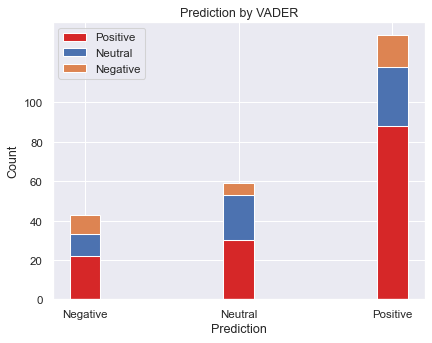

In [38]:
plot_prediction_bar('vadar_result','VADER')

## 2.2 Opinion Lexicon Method

In [105]:
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import sentiwordnet
from nltk.corpus import wordnet
import nltk
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score,\
recall_score,accuracy_score,roc_auc_score,classification_report

from nltk.corpus import opinion_lexicon
import numpy as np
import matplotlib.pyplot as plt

In [52]:
def score_from_opinion_lexicon(text):
    pos_words = set(text.split(' ')).intersection(set(opinion_lexicon.positive()))
    neg_words = set(text.split(' ')).intersection(set(opinion_lexicon.negative()))
    pos_num = len(pos_words)
    neg_num = len(neg_words)
    score = pos_num - neg_num
    return {'score':score,'pos_words':pos_words,'neg_words':neg_words}

In [53]:
df['score_opnion_lexicon'] = df['clean_sentence'].apply(lambda x:score_from_opinion_lexicon(x))

In [54]:
df['predicted_opnion_lexicon'] = df['score_opnion_lexicon'].apply(lambda x:'Positive' if x['score']>0 \
                                                                  else 'Negative' if x['score']<0 else 'Neutral')

In [55]:
df['predicted_opnion_lexicon'].value_counts()

Positive    100
Neutral      91
Negative     45
Name: predicted_opnion_lexicon, dtype: int64

In [66]:
df['predicted_opnion_lexicon']

0      Positive
1      Positive
2      Positive
3      Positive
4      Positive
         ...   
261     Neutral
262    Negative
263     Neutral
264    Negative
265    Negative
Name: predicted_opnion_lexicon, Length: 236, dtype: object

In [80]:
df['predicted_opnion_lexicon'].value_counts()

Positive    100
Neutral      91
Negative     45
Name: predicted_opnion_lexicon, dtype: int64

In [70]:
df['score_opnion_lexicon'].apply(lambda x:x['pos_words']).value_counts().head(11)

{}              112
{support}        14
{consistent}      7
{regard}          5
{sufficient}      4
{adequate}        4
{benefit}         4
{durable}         3
{available}       3
{well}            3
{important}       3
Name: score_opnion_lexicon, dtype: int64

In [65]:
df['score_opnion_lexicon'].apply(lambda x:x['neg_words']).value_counts().head(11)

{}                162
{concern}          10
{issue}             5
{risk}              4
{severe}            3
{adverse}           3
{pain}              2
{atrophy}           2
{inconsistent}      2
{severity}          2
{limit}             2
Name: score_opnion_lexicon, dtype: int64

In [56]:
print(classification_report(df['label'],df['predicted_opnion_lexicon']))

              precision    recall  f1-score   support

    Negative       0.38      0.53      0.44        32
     Neutral       0.29      0.41      0.34        64
    Positive       0.71      0.51      0.59       140

    accuracy                           0.48       236
   macro avg       0.46      0.48      0.46       236
weighted avg       0.55      0.48      0.50       236



In [74]:
def text_score(text,stop_word_list):
    #create word lsit
    #nltk.pos_tag是打标签
    ttt = nltk.pos_tag([i for i in word_tokenize(str(text).lower()) if i not in stop_word_list])
    word_tag_fq = nltk.FreqDist(ttt)
    wordlist = word_tag_fq.most_common()

    key = []
    part = []
    frequency = []
    for i in range(len(wordlist)):
        key.append(wordlist[i][0][0])
        part.append(wordlist[i][0][1])
        frequency.append(wordlist[i][1])
    textdf = pd.DataFrame({'key':key,
                      'part':part,
                      'frequency':frequency},
                      columns=['key','part','frequency'])

    #编码
    n = ['NN','NNP','NNPS','NNS','UH']
    v = ['VB','VBD','VBG','VBN','VBP','VBZ']
    a = ['JJ','JJR','JJS']
    r = ['RB','RBR','RBS','RP','WRB']

    for i in range(len(textdf['key'])):
        z = textdf.iloc[i,1]

        if z in n:
            textdf.iloc[i,1]='n'
        elif z in v:
            textdf.iloc[i,1]='v'
        elif z in a:
            textdf.iloc[i,1]='a'
        elif z in r:
            textdf.iloc[i,1]='r'
        else:
            textdf.iloc[i,1]=''
            
    #Calculate sentiment score of a sentence
    score = []
    for i in range(len(textdf['key'])):
        m = list(swn.senti_synsets(textdf.iloc[i,0],textdf.iloc[i,1]))
        s = 0
        ra = 0
        if len(m) > 0:
            for j in range(len(m)):
                s += (m[j].pos_score()-m[j].neg_score())/(j+1)
                ra += 1/(j+1)
            score.append(s/ra)
        else:
            score.append(0)
        #pd.concat([textdf,pd.DataFrame({'score':score})],axis=1),    
    return sum(score)


In [61]:
stop_words = stopwords.words('english')
stop_words = list(set(stop_words)-{'no','nor','not',"don't","aren't",
                                      "couldn't","didn't", "doesn't", "hadn't",
                                      "hasn't",  "haven't", "isn't",  "mightn't",
                                      "mustn't",  "needn't",  "shan't", "shouldn't",
                                       "wasn't", 'weren', "weren't",  "won't", "wouldn't"})

In [76]:
df['Sentence'].apply(lambda x:text_score(x,stop_words)).value_counts()

 0.000    199
 0.375     15
 0.125     13
-0.500      5
 0.250      3
-0.125      1
Name: Sentence, dtype: int64

# MACHINE LEARNING METHODS

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix

In [43]:
def plot_prediction_test_train_bar(column,index_train,index_test,method):
    '''
    bar plot of prediction vs truth
    '''
    confusion_mat_train = confusion_matrix(df['label'][index_train],df[column][index_train])
    confusion_mat_test = confusion_matrix(df['label'][index_test],df[column][index_test])

    ind_train = [0,5,10]  
    ind_test = [2,7,12]
    # the x locations for the groups
    width = 1       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind_train, confusion_mat_train[2,:],width, color='#d62728')
    p2 = plt.bar(ind_train, confusion_mat_train[1,:], width,bottom = confusion_mat_train[2,:],color = 'navy')
    p3 = plt.bar(ind_train, confusion_mat_train[0,:], width, bottom = confusion_mat_train[2,:]+confusion_mat_train[1,:],color='purple')
    
    p4 = plt.bar(ind_test, confusion_mat_test[2,:],width, color='#d62728')
    p5 = plt.bar(ind_test, confusion_mat_test[1,:], width,bottom = confusion_mat_test[2,:],color='navy')
    p6 = plt.bar(ind_test, confusion_mat_test[1,:], width,bottom = confusion_mat_test[2,:]+confusion_mat_test[1,:],color='purple')
    
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.title('Prediction by '+method)
    plt.xticks([1,6,11],('Negative','Neutral','Positive'))
    plt.yticks(np.arange(0, 101, 20))
    plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neutral', 'Negative'))

    plt.show()

In [21]:
X=df['clean_sentence']
y=df['label'].map({'Positive':1,'Negative':-1,'Neutral':0})
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.2,random_state=0)

In [22]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2))

In [23]:
X_train_transformed=tfidf_vec.fit_transform(X_train)

In [45]:
# Naive Bayes Model
nb=MultinomialNB()
nb.fit(X_train_transformed, y_train)
X_test_transformed=tfidf_vec.transform(X_test)

In [46]:
print(classification_report(y_test,nb.predict(X_test_transformed),target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         8
     Neutral       0.00      0.00      0.00        11
    Positive       0.60      1.00      0.75        29

    accuracy                           0.60        48
   macro avg       0.20      0.33      0.25        48
weighted avg       0.37      0.60      0.46        48



/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [47]:
# Model Evaluation
print(f'Test Score: {nb.score(X_test_transformed, y_test)}')
print(f'Train Score: {nb.score(X_train_transformed, y_train)}')

Test Score: 0.6041666666666666
Train Score: 0.8191489361702128


In [48]:
df['Predicted_NB'] = nb.predict(tfidf_vec.transform(X))
df['Predicted_NB'] = df['Predicted_NB'].map({1:'Positive',0:'Neutral',-1:'Negative'})

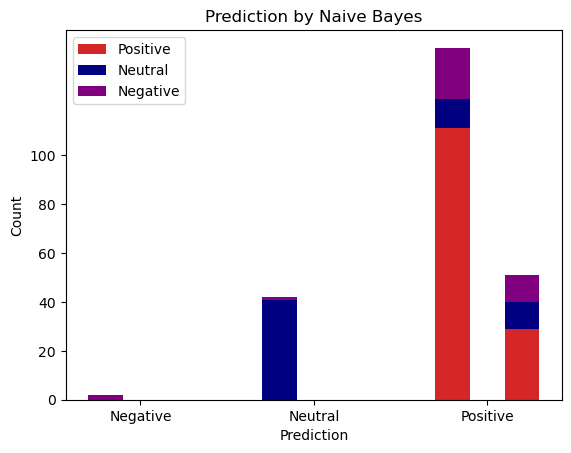

In [49]:
plot_prediction_test_train_bar('Predicted_NB',X_train.index,X_test.index,'Naive Bayes')

In [71]:
accuracy_score(df['label'],df['Predicted_NB'])

0.7754237288135594

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
lr = LogisticRegression()
lr.fit(X_train_transformed, y_train)
#accuracy_score(lr.predict(X_test_transformed),y_test)

print(classification_report(lr.predict(X_test_transformed),y_test,target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       0.25      1.00      0.40         2
     Neutral       0.00      0.00      0.00         0
    Positive       1.00      0.63      0.77        46

    accuracy                           0.65        48
   macro avg       0.42      0.54      0.39        48
weighted avg       0.97      0.65      0.76        48



/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
rf = RandomForestClassifier(max_depth=500,n_estimators=1000,max_features=1000)
rf.fit(X_train_transformed, y_train)
accuracy_score(rf.predict(X_test_transformed),y_test)
print(classification_report(rf.predict(X_test_transformed),y_test,target_names=['Negative','Neutral','Positive']))

              precision    recall  f1-score   support

    Negative       0.25      1.00      0.40         2
     Neutral       0.36      0.44      0.40         9
    Positive       0.90      0.70      0.79        37

    accuracy                           0.67        48
   macro avg       0.50      0.72      0.53        48
weighted avg       0.77      0.67      0.70        48



In [37]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(max_depth=1000,n_estimators=1000,learning_rate=0.05)
lgb_model.fit(X_train_transformed,y_train)

LGBMClassifier(learning_rate=0.05, max_depth=1000, n_estimators=1000)

In [39]:
df['Predicted_lgb'] = lgb_model.predict(tfidf_vec.transform(X))
df['Predicted_lgb'] = df['Predicted_lgb'].map({1:'Positive',0:'Neutral',-1:'Negative'})

In [40]:
print(accuracy_score(lgb_model.predict(X_test_transformed),y_test))

print(classification_report(lgb_model.predict(X_test_transformed),y_test,target_names=['Negative','Neutral','Positive']))

0.5625
              precision    recall  f1-score   support

    Negative       0.12      0.50      0.20         2
     Neutral       0.00      0.00      0.00         3
    Positive       0.90      0.60      0.72        43

    accuracy                           0.56        48
   macro avg       0.34      0.37      0.31        48
weighted avg       0.81      0.56      0.66        48



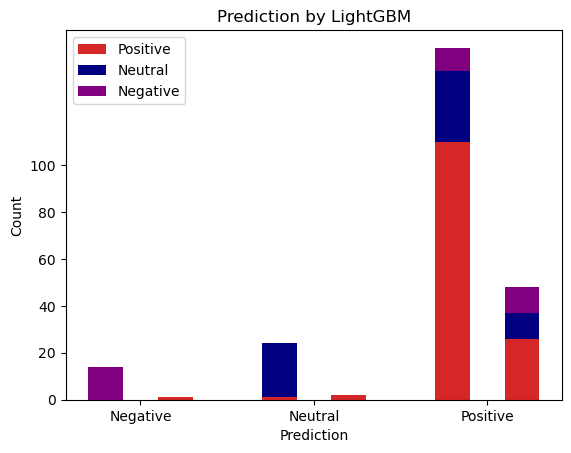

In [51]:
plot_prediction_test_train_bar('Predicted_lgb',X_train.index,X_test.index,'LightGBM')

# Deep Learning Methods

In [24]:
from keras.layers import Dense
from tensorflow.python.keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd

In [25]:
from collections import Counter
counts = Counter()
for i,review in enumerate(df['clean_text']):
    counts.update(review.split())
words = sorted(counts, key=counts.get, reverse=True)

nb_chars = len(words)
print(nb_chars)
word_to_int = {word: i for i, word in enumerate(words, 1)}
int_to_word = {i: word for i, word in enumerate(words, 1)}

1280


In [26]:
mapped_reviews = []
for review in df['clean_text']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])

# 打印示例
print('Original text:',df.loc[0]['clean_text'])
print('Mapped text:',mapped_reviews[0])


Original text: results 2nd line treatment show orr 33 patients durable responses resulting apparent pfs plateau
Mapped text: [16, 279, 68, 7, 280, 649, 650, 4, 281, 405, 651, 652, 226, 653]


In [27]:
length_sent = []
for i in range(len(mapped_reviews)):
    length_sent.append(len(mapped_reviews[i]))

sequence_length = max(length_sent)

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x = pad_sequences(maxlen=sequence_length, sequences=mapped_reviews, padding="post", value=0)
y = df['label'].values
y = np.array(pd.get_dummies(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)

In [32]:
embedding_vector_length=100
max_review_length=30
model = Sequential()
model.add(Embedding(input_dim=nb_chars+1, output_dim=max_review_length, input_length = embedding_vector_length))

model.add(SimpleRNN(50, return_sequences=False))

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x_train,\
          y_train,\
          batch_size=256,\
          epochs=50,\
          validation_data=(x_test,y_test))
model.summary()

Epoch 1/50
1/1 [==============================] - 0s 465ms/step - loss: 1.1207 - acc: 0.2123 - val_loss: 1.0574 - val_acc: 0.5556
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 1.0347 - acc: 0.6226 - val_loss: 0.9870 - val_acc: 0.6852
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.9696 - acc: 0.6321 - val_loss: 0.9291 - val_acc: 0.6852
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.9210 - acc: 0.5991 - val_loss: 0.8885 - val_acc: 0.6852
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 0.8852 - acc: 0.5896 - val_loss: 0.8650 - val_acc: 0.6852
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.8495 - acc: 0.5943 - val_loss: 0.8548 - val_acc: 0.6852
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.7985 - acc: 0.6415 - val_loss: 0.8562 - val_acc: 0.6481
Epoch 8/50
1/1 [==============================] - 0s 21ms/step - loss: 0.7262 - acc: 0.7264 - va

In [33]:
#LSTM拟合

In [34]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import *

In [35]:
import pickle

In [36]:
def load_data(df, input_shape=20):
    # 标签及词汇表
    labels, vocabulary = list(df['label'].unique()), list(df['clean_text'].unique())
    # 构造字符级别的特征
    string = ''
    for word in vocabulary:
        string += word
    vocabulary = set(string)
    # 字典列表
    word_dictionary = {word: i+1 for i, word in enumerate(vocabulary)}
    with open('word_dict.pk', 'wb') as f:
        pickle.dump(word_dictionary, f)
    inverse_word_dictionary = {i+1: word for i, word in enumerate(vocabulary)}
    label_dictionary = {label: i for i, label in enumerate(labels)}
    with open('label_dict.pk', 'wb') as f:
        pickle.dump(label_dictionary, f)
    output_dictionary = {i: labels for i, labels in enumerate(labels)}
    vocab_size = len(word_dictionary.keys()) # 词汇表大小
    label_size = len(label_dictionary.keys()) # 标签类别数量
    # 序列填充，按input_shape填充，长度不足的按0补充
    x = [[word_dictionary[word] for word in sent] for sent in df['clean_text']]
    x = pad_sequences(maxlen=input_shape, sequences=x, padding='post', value=0)
    y = [[label_dictionary[sent]] for sent in df['label']]
    y = [to_categorical(label, num_classes=label_size) for label in y]
    y = np.array([list(_[0]) for _ in y])
    return x, y, output_dictionary, vocab_size, label_size, inverse_word_dictionary

In [41]:
x, y, output_dictionary, vocab_size, label_size, inverse_word_dictionary = load_data(df,input_shape=500)

In [47]:
input_shape = 500
output_dim = 100
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size + 1, output_dim=output_dim,
                    input_length=input_shape, mask_zero=True))
lstm_model.add(LSTM(3, input_shape=(x.shape[0], x.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(label_size, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#plot_model(model, to_file='./model_lstm.png', show_shapes=True)

In [48]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [49]:
lstm_model.fit(train_x, train_y, epochs=100, batch_size=128,validation_data=(test_x,test_y))
# 模型保存
lstm_model.save('lstm.pkl')
N = test_x.shape[0]  # 测试的条数
predict = []
label = []
for start, end in zip(range(0, N, 1), range(1, N+1, 1)):
    sentence = [inverse_word_dictionary[i] for i in test_x[start] if i != 0]
    y_predict = lstm_model.predict(test_x[start:end])
    label_predict = output_dictionary[np.argmax(y_predict[0])]
    label_true = output_dictionary[np.argmax(test_y[start:end])]
    print(''.join(sentence), label_true, label_predict) # 输出预测结果
    predict.append(label_predict)
    label.append(label_true)
acc = accuracy_score(predict, label) # 预测准确率
print('模型在测试集上的准确率为: %s.' % acc)

Epoch 1/100
2/2 [==============================] - 2s 585ms/step - loss: 1.1011 - accuracy: 0.2689 - val_loss: 1.0924 - val_accuracy: 0.5556
Epoch 2/100
2/2 [==============================] - 0s 137ms/step - loss: 1.0885 - accuracy: 0.5755 - val_loss: 1.0829 - val_accuracy: 0.5556
Epoch 3/100
2/2 [==============================] - 0s 135ms/step - loss: 1.0775 - accuracy: 0.6085 - val_loss: 1.0737 - val_accuracy: 0.5556
Epoch 4/100
2/2 [==============================] - 0s 133ms/step - loss: 1.0644 - accuracy: 0.6179 - val_loss: 1.0644 - val_accuracy: 0.5556
Epoch 5/100
2/2 [==============================] - 0s 136ms/step - loss: 1.0528 - accuracy: 0.6132 - val_loss: 1.0550 - val_accuracy: 0.5556
Epoch 6/100
2/2 [==============================] - 0s 135ms/step - loss: 1.0388 - accuracy: 0.6132 - val_loss: 1.0456 - val_accuracy: 0.5556
Epoch 7/100
2/2 [==============================] - 0s 134ms/step - loss: 1.0261 - accuracy: 0.6132 - val_loss: 1.0363 - val_accuracy: 0.5556
Epoch 8/100
2

Epoch 59/100
2/2 [==============================] - 0s 133ms/step - loss: 0.8747 - accuracy: 0.6226 - val_loss: 0.9664 - val_accuracy: 0.5556
Epoch 60/100
2/2 [==============================] - 0s 133ms/step - loss: 0.8467 - accuracy: 0.6226 - val_loss: 0.9669 - val_accuracy: 0.5556
Epoch 61/100
2/2 [==============================] - 0s 135ms/step - loss: 0.8621 - accuracy: 0.6274 - val_loss: 0.9672 - val_accuracy: 0.5556
Epoch 62/100
2/2 [==============================] - 0s 134ms/step - loss: 0.8284 - accuracy: 0.6274 - val_loss: 0.9687 - val_accuracy: 0.5556
Epoch 63/100
2/2 [==============================] - 0s 134ms/step - loss: 0.8591 - accuracy: 0.6226 - val_loss: 0.9702 - val_accuracy: 0.5556
Epoch 64/100
2/2 [==============================] - 0s 133ms/step - loss: 0.8761 - accuracy: 0.6179 - val_loss: 0.9713 - val_accuracy: 0.5556
Epoch 65/100
2/2 [==============================] - 0s 133ms/step - loss: 0.8484 - accuracy: 0.6226 - val_loss: 0.9723 - val_accuracy: 0.5556
Epoch 

INFO:tensorflow:Assets written to: lstm.pkl/assets


INFO:tensorflow:Assets written to: lstm.pkl/assets


1/1 [==============================] - 0s 443ms/step
also support need early treatment nusinersen since shortly loading phase complete rate ventilation among nusinersen treated subjects separated controls Positive Positive
1/1 [==============================] - 0s 20ms/step
particular interest fdc comprises two pangenotypic components high potency high genetic barrier Neutral Positive
1/1 [==============================] - 0s 21ms/step
objectives study ct p10 3 3 demonstrate similarity pharmacokinetics non inferiority efficacy ct p10 rituxan primary endpoints coadministered cvp patients advanced fl objectives met furthermore extrapolation context nhl cll indications acceptable Positive Positive
1/1 [==============================] - 0s 21ms/step
lack long term data beyond 30 weeks frc Negative Positive
1/1 [==============================] - 0s 21ms/step
overall safety profile pps considered concern Positive Positive
1/1 [==============================] - 0s 21ms/step
8 week course sof 

1/1 [==============================] - 0s 20ms/step
embrace sm202 phase 2 randomized double blind sham procedure controlled study assess safety tolerability pk efficacy patients eligible participate studies cs3b cs4 Neutral Positive
1/1 [==============================] - 0s 20ms/step
study triple 5 triple therapy bdp ff gb chf 5993 statistically significant clinically relevant superior effect pre dose 2 h post dose fev1 week 26 bdp ff foster Positive Positive
1/1 [==============================] - 0s 19ms/step
nusinersen demonstrated favourable safety efficacy pattern treatment infantile onset sma randomized controlled clinical study study cs3b Positive Positive
1/1 [==============================] - 0s 19ms/step
superiority placebo demonstrated dupilumab doses monotherapy combination tcs ad patients insufficiently controlled topical therapies alone Positive Positive
1/1 [==============================] - 0s 20ms/step
pivotal ra trial efficacy results terms das28 acr shown comparable c

## BERT

In [86]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Load data and set labels
df = pd.read_excel('sentiment_sentences.xlsx')

df[['Sentence','label']].drop_duplicates(inplace=True)

from sklearn.model_selection import train_test_split
X = df.Sentence.values
y = df.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=0)

import torch
device = torch.device("cpu")

/Users/yuxueqi/miniforge3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [88]:
import nltk
from nltk.corpus import stopwords

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [92]:
from transformers import BertTokenizer

ModuleNotFoundError: No module named 'huggingface_hub'

In [91]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

ModuleNotFoundError: No module named 'huggingface_hub'